In [39]:
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imread
import cv2
from skimage import color
import numpy.linalg as la

In [40]:
def generate_superpixels(image_path, k):
    """
    Generates and displays superpixels for a given image using the SLIC algorithm.

    Parameters:
    - image_path: Path to the image file.
    - k: The desired number of superpixels.

    Returns:
    - A visualization of the superpixels overlaid on the original image.
    """

    # Load the image
    image = imread(image_path)

    # Apply SLIC and obtain the segment labels
    segments = slic(image, n_segments=k, compactness=10,
                    sigma=1, start_label=1)

    # Create an image showing the superpixel boundaries
    superpixels = label2rgb(segments, image, kind='avg')

    # Display the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(superpixels)
    ax[1].set_title(f'Superpixels with k={k}')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

    return superpixels

# Example usage:
# generate_superpixels('path_to_your_image.jpg', k=200)


In [41]:
test_path = './logo-dataset/acura/images/0aa5a789508cd718fc4cf044352375ed54080b5e.png'


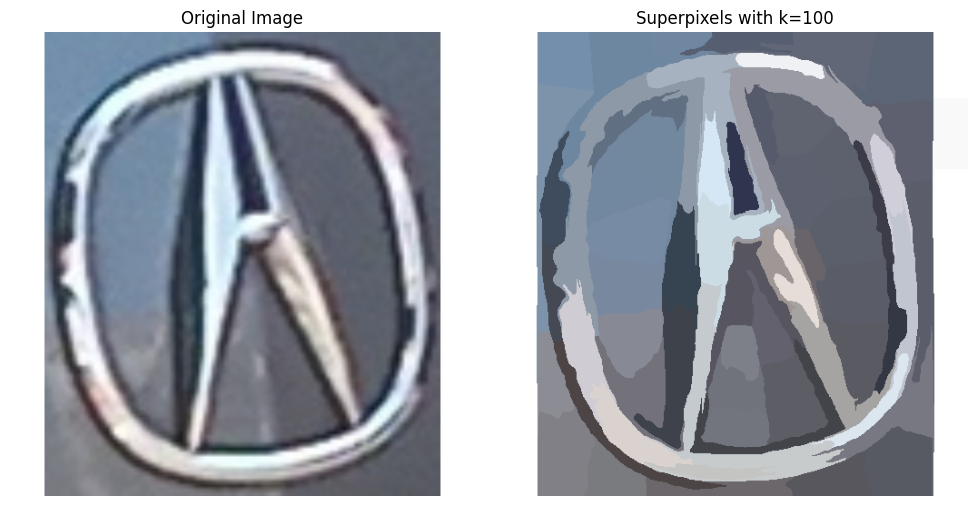

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [42]:
generate_superpixels(test_path, 100)

In [43]:
def calculate_gradient(image_lab):
    gradient = np.zeros((image_lab.shape[0] - 1, image_lab.shape[1] - 1))
    for i in range(1, image_lab.shape[0] - 1):
        for j in range(1, image_lab.shape[1] - 1):
            gx = image_lab[i + 1, j, :] - image_lab[i - 1, j, :]
            gy = image_lab[i, j + 1, :] - image_lab[i, j - 1, :]
            gradient[i, j] = np.sum(gx**2) + np.sum(gy**2)
    return gradient


In [56]:
def get_optimized_cluster_centers(image, K):
    height, width = image.shape[:2]

    S = int(np.sqrt(height*width/K))

    cluster_centers = []

    # compute gradient and adjust centers

    gradient = calculate_gradient(image)

    threshold = np.percentile(gradient, 85)

    for i in range(0, height - S, S):
        for j in range(0, width - S, S):
            center_i, center_j = i + S // 2, j + S // 2
            
            min_pos = (center_i, center_j)

            if gradient[center_i,center_j] >= threshold:

                # neighborhood to search for lowest gradient point
                neighborhood_size = S // 4
                half_size = neighborhood_size // 2

                min_gradient = gradient[center_i, center_j]

                # search for lowest gradient
                for ni in range(max(0, center_i - half_size), min(height, center_i + half_size + 1)):
                    for nj in range(max(0, center_j - half_size), min(width, center_j + half_size + 1)):
                        if gradient[ni, nj] < min_gradient:
                            min_gradient = gradient[ni, nj]
                            min_pos = (ni, nj)

            cluster_centers.append(min_pos)
	
    normalized_gradient = gradient / gradient.max()

    # This will require normalization and type conversion
    plt.imshow(normalized_gradient, cmap='plasma')

    # plt.imshow(gradient, cmap='plasma', vmin=gradient.min(), vmax=gradient.max())
    plt.colorbar()  # Optional, but useful for showing the scale of the gradient values
    plt.show()

    return cluster_centers

In [54]:
def slic_superpixels(image, K, m, num_iterations=6):

    # convert image to LAB
    lab_image = color.rgb2lab(image)

    height, width = image.shape[:2]

    print(height, width)

    N = height * width  # total number of pixels in the image
    A = N / K           # area of superpixel
    S = int(np.sqrt(A))  # length of each superpixel

    cluster_centers_initial = get_optimized_cluster_centers(image, K)

    # Initialize labels and distances
    labels = -1 * np.ones(image.shape[:2], np.int32)
    distances = np.inf * np.ones(image.shape[:2], np.float64)

    spatial_scale = m/S

    cluster_centers_final = cluster_centers_initial.copy()

    # SLIC algorithm
    for _ in range(num_iterations):
        for ci, center in enumerate(cluster_centers_final):
            cx, cy = center
            # search in 2S range
            for i in range(max(0, cx - S), min(height, cx + S)):
                for j in range(max(0, cy - S), min(width, cy + S)):
                    
                    d_lab = math.dist(lab_image[cx, cy], lab_image[i, j])
                    d_spatial = math.dist([cx, cy], [i, j])

                    d = d_lab + spatial_scale * d_spatial

                    if d < distances[i, j]:
                        distances[i, j] = d
                        labels[i, j] = ci

        # update cluster centers
        for ci in range(len(cluster_centers_final)):
            members = np.where(labels == ci)
            if members[0].size > 0:
                new_center_x = np.mean(members[0])
                new_center_y = np.mean(members[1])
                cluster_centers_final[ci] = (
                    int(new_center_x), int(new_center_y))

    final_image = np.zeros_like(image)

    ## reconstruct final image here ##
    for ci in range(len(cluster_centers_final)):
        members = np.where(labels == ci)
        if members[0].size > 0:
            for channel in range(3):  # Assuming image has 3 channels
                final_image[members[0], members[1], channel] = np.mean(image[members[0], members[1], channel])

    return final_image, labels, cluster_centers_initial, cluster_centers_final

512 512


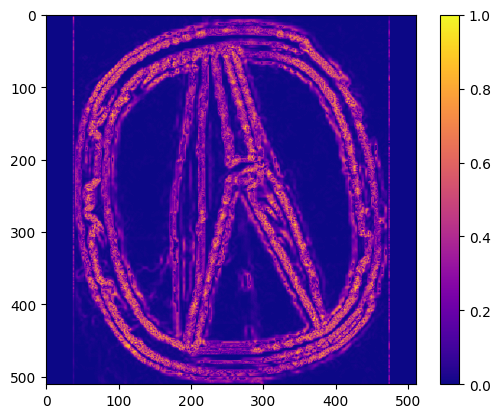

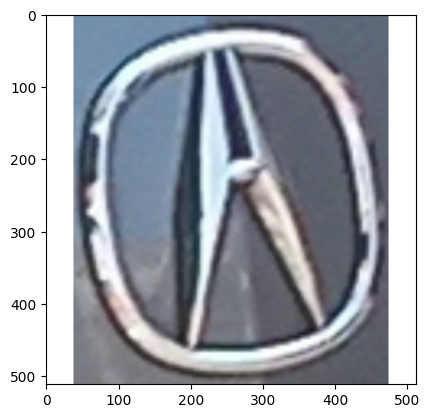

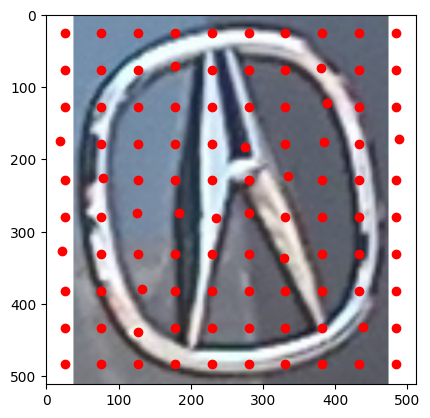

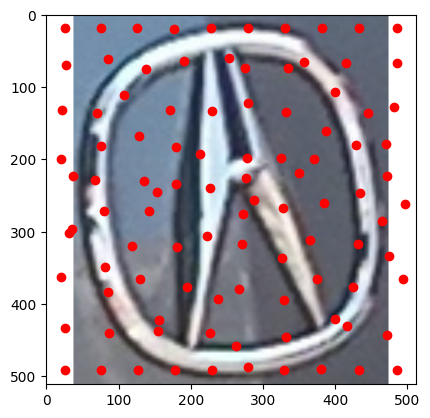

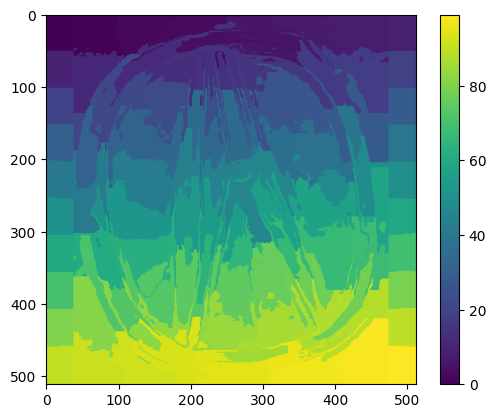

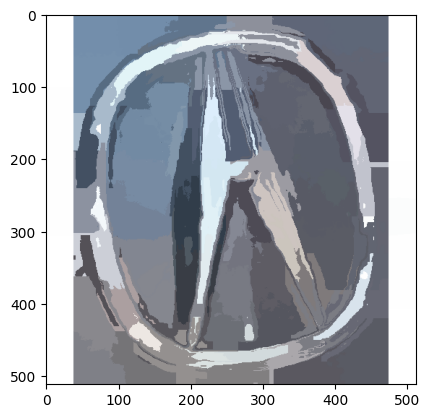

In [57]:
image = cv2.imread(test_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
final_img, superpixels, cluster_centers_initial, cluster_centers_final = slic_superpixels(image, K=100, m=2)

plt.imshow(image)

plt.figure()

plt.imshow(image)
# Placing a dot on each coordinate
for x, y in cluster_centers_initial:
    plt.plot(x, y, 'ro')  # 'ro' stands for red color and circle marker

# Optional: Remove axis ticks and labels
# plt.axis('off')

# Show the modified image
plt.show()

plt.figure()

plt.imshow(image)
# Placing a dot on each coordinate
for x, y in cluster_centers_final:
    plt.plot(x, y, 'ro')  # 'ro' stands for red color and circle marker

# Optional: Remove axis ticks and labels
# plt.axis('off')

# Show the modified image
plt.show()

plt.figure()

plt.imshow(superpixels)
plt.colorbar()
plt.show()

plt.figure()

plt.imshow(final_img)
plt.show()
